In [1]:
%load_ext autoreload
%autoreload 2

In [23]:
import pandas as pd
import numpy as np
import timm
import torch
from tqdm import tqdm
from sklearn import svm
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.ensemble import RandomForestClassifier
from PIL import Image
Image.MAX_IMAGE_PIXELS = None

from src.model.swin_transformer_v2_classifier import SwinTransformerV2Classifier
from src.data.visiomel_datamodule import VisiomelDatamodule
from src.utils.utils import extract_features, extract_features_single, extract_features_patches

# Pretrained

In [2]:
model = timm.create_model(
    'swinv2_large_window12to24_192to384_22kft1k', 
    pretrained=True, 
    num_classes=0
).cuda().eval()

/root/miniconda3/envs/visiomel-2023/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [3]:
P = 384

### No patches

In [ ]:
datamodule = VisiomelDatamodule(
    task='classification',
    data_dir_train = '/workspace/data/images_page_7/',	
    k = 5,
    fold_index = 0,
    data_dir_test = None,
    img_size = 384,
    shrink_preview_scale = None,
    batch_size = 32,
    split_seed = 0,
    num_workers = 0,
    pin_memory = False,
    prefetch_factor = None,
    persistent_workers = False,
    sampler = None,
    data_shrinked=False,
    num_workers_saturated=10,
    enable_caching=False,
    train_resize_type='resize',
)
datamodule.setup()
train_dataloader = datamodule.train_dataloader()
val_dataloader, _ = datamodule.val_dataloader()

In [4]:
features_all, y_all = extract_features(model, train_dataloader)

100%|██████████| 34/34 [01:48<00:00,  3.20s/it]


In [7]:
features_all_val, y_all_val = extract_features(model, val_dataloader)

100%|██████████| 9/9 [00:25<00:00,  2.86s/it]


In [8]:
features_all.shape, y_all.shape

(torch.Size([1073, 4416]), torch.Size([1073]))

In [10]:
# SVM classifier on features_all and y_all
clf = svm.SVC(kernel='linear', C=1, probability=True).fit(features_all.cpu().numpy(), y_all.cpu().numpy())

# Predict on validation set
y_all_val_pred = clf.predict_proba(features_all_val.cpu().numpy())

# log_loss
log_loss(y_all_val.cpu().numpy(), y_all_val_pred, eps=1e-16)

0.4148100175016549

In [11]:
# Predict on train set
y_all_pred = clf.predict_proba(features_all.cpu().numpy())

# log_loss
log_loss(y_all.cpu().numpy(), y_all_pred, eps=1e-16)

0.2855574374923769

### Patches

In [6]:
datamodule = VisiomelDatamodule(
    task='classification',
    data_dir_train = '/workspace/data/images_page_7/',	
    k = 5,
    fold_index = 0,
    data_dir_test = None,
    img_size = 384 * 2,
    shrink_preview_scale = None,
    batch_size = 4,
    split_seed = 0,
    num_workers = 0,
    pin_memory = False,
    prefetch_factor = None,
    persistent_workers = False,
    sampler = None,
    data_shrinked=False,
    num_workers_saturated=10,
    enable_caching=False,
    train_resize_type='resize',
)
datamodule.setup()
train_dataloader = datamodule.train_dataloader()
val_dataloader, _ = datamodule.val_dataloader()

In [7]:
features_all, y_all = extract_features_patches(model, train_dataloader)

100%|██████████| 269/269 [14:43<00:00,  3.28s/it]


In [8]:
features_all_val, y_all_val = extract_features_patches(model, val_dataloader)

100%|██████████| 68/68 [04:13<00:00,  3.73s/it]


In [9]:
features_all.shape, y_all.shape

(torch.Size([9657, 4416]), torch.Size([1073]))

In [13]:
features_all.reshape(y_all.shape[0], features_all.shape[1], -1).flatten(1).shape

torch.Size([1073, 39744])

In [15]:
features_all = features_all.reshape(y_all.shape[0], features_all.shape[1], -1).flatten(1)
features_all_val = features_all_val.reshape(y_all_val.shape[0], features_all_val.shape[1], -1).flatten(1)

In [18]:
features_all.shape

torch.Size([1073, 39744])

In [16]:
# SVM classifier on features_all and y_all
clf = svm.SVC(kernel='linear', C=1, probability=True).fit(features_all.cpu().numpy(), y_all.cpu().numpy())

# Predict on validation set
y_all_val_pred = clf.predict_proba(features_all_val.cpu().numpy())

# log_loss
log_loss(y_all_val.cpu().numpy(), y_all_val_pred, eps=1e-16)

0.40077315802046426

In [17]:
# Predict on train set
y_all_pred = clf.predict_proba(features_all.cpu().numpy())

# log_loss
log_loss(y_all.cpu().numpy(), y_all_pred, eps=1e-16)

0.24109060020013015

# SSUP

In [ ]:
state_dict = {
    k \
        .replace('model.encoder.', 'model.'): v 
    for k, v in 
    torch.load('/workspace/visiomel-2023/visiomel/eahzd753/checkpoints/last.ckpt')['state_dict'].items()
}
model = SwinTransformerV2Classifier(
    model_name='swinv2_large_window12to24_192to384_22kft1k', 
    num_classes=0, 
    img_size=1536, 
    patch_size=4,
)
model.load_state_dict(state_dict, strict=False)
model = model.cuda()

/root/miniconda3/envs/visiomel-2023/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
_IncompatibleKeys(missing_keys=['layers.0.blocks.1.attn_mask', 'layers.1.blocks.1.attn_mask', 'layers.2.blocks.1.attn_mask', 'layers.2.blocks.3.attn_mask', 'layers.2.blocks.5.attn_mask', 'layers.2.blocks.7.attn_mask', 'layers.2.blocks.9.attn_mask', 'layers.2.blocks.11.attn_mask', 'layers.2.blocks.13.attn_mask', 'layers.2.blocks.15.attn_mask', 'layers.2.blocks.17.attn_mask', 'layers.3.blocks.1.attn_mask'], unexpected_keys=[])


In [ ]:
datamodule = VisiomelDatamodule(
    task='simmim',
    data_dir_train = '/workspace/data/images_page_4_shrink/',	
    data_dir_test = None,
    img_size = 1536,
    shrink_preview_scale = None,
    batch_size = 2,
    split_seed = 0,
    num_workers = 4,
    pin_memory = False,
    prefetch_factor = None,
    persistent_workers = False,
    sampler = None,
    data_shrinked=True,
    num_workers_saturated=4,
    enable_caching=False,
    train_resize_type='resize',
)
datamodule.setup()
train_dataloader = datamodule.train_dataloader()

In [ ]:
features_all, y_all = extract_features(model.model, train_dataloader)

100%|██████████| 671/671 [10:28<00:00,  1.07it/s]


In [ ]:
features_all.shape, y_all.shape

(torch.Size([1342, 4416]), torch.Size([1342]))

In [ ]:
features_all, features_all_val, y_all, y_all_val = train_test_split(features_all, y_all, test_size=0.2, random_state=0)

In [ ]:
# SVM classifier on features_all and y_all
clf = svm.SVC(kernel='linear', C=1, probability=True).fit(features_all.cpu().numpy(), y_all.cpu().numpy())

# Predict on validation set
y_all_val_pred = clf.predict_proba(features_all_val.cpu().numpy())

# log_loss
log_loss(y_all_val.cpu().numpy(), y_all_val_pred, eps=1e-16)

0.35908364195215864

In [ ]:
# Predict on train set
y_all_pred = clf.predict_proba(features_all.cpu().numpy())

# log_loss
log_loss(y_all.cpu().numpy(), y_all_pred, eps=1e-16)

0.28846559331031174

# SSUP without shrink

In [4]:
state_dict = {
    k \
        .replace('model.encoder.', 'model.'): v 
    for k, v in 
    torch.load('/workspace/visiomel-2023/weights/no_val_ssup/checkpoints/last.ckpt')['state_dict'].items()
}
model = SwinTransformerV2Classifier(
    model_name='swinv2_large_window12to24_192to384_22kft1k', 
    num_classes=0, 
    img_size=1536, 
    patch_size=4,
)
model.load_state_dict(state_dict, strict=False)
model = model.cuda()

/root/miniconda3/envs/visiomel-2023/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
_IncompatibleKeys(missing_keys=['layers.0.blocks.1.attn_mask', 'layers.1.blocks.1.attn_mask', 'layers.2.blocks.1.attn_mask', 'layers.2.blocks.3.attn_mask', 'layers.2.blocks.5.attn_mask', 'layers.2.blocks.7.attn_mask', 'layers.2.blocks.9.attn_mask', 'layers.2.blocks.11.attn_mask', 'layers.2.blocks.13.attn_mask', 'layers.2.blocks.15.attn_mask', 'layers.2.blocks.17.attn_mask', 'layers.3.blocks.1.attn_mask'], unexpected_keys=[])


In [5]:
datamodule = VisiomelDatamodule(
    task='simmim',
    data_dir_train = '/workspace/data/images_page_4/',	
    k=None,
    data_dir_test = None,
    img_size = 1536,
    shrink_preview_scale = 8,
    batch_size = 2,
    split_seed = 0,
    num_workers = 4,
    pin_memory = False,
    prefetch_factor = None,
    persistent_workers = False,
    sampler = None,
    data_shrinked=False,
    num_workers_saturated=4,
    enable_caching=False,
    train_resize_type='resize',
)
datamodule.setup()
train_dataloader = datamodule.train_dataloader()

In [6]:
features_all, y_all = extract_features(model.model, train_dataloader)

100%|██████████| 671/671 [20:19<00:00,  1.82s/it]


In [7]:
features_all.shape, y_all.shape

(torch.Size([1342, 4416]), torch.Size([1342]))

In [8]:
features_all, y_all = features_all.cpu().numpy(), y_all.cpu().numpy()

In [9]:
features_train, features_test, y_train, y_test = train_test_split(
    features_all, y_all, test_size=0.2, random_state=0, stratify=y_all
)

Stratified single split SVC

In [10]:
# SVM classifier on features_all and y_all
clf = svm.SVC(kernel='linear', C=1, probability=True).fit(features_train, y_train)

# Predict on validation set
y_test_pred = clf.predict_proba(features_test)

# log_loss
log_loss(y_test, y_test_pred, eps=1e-16)

0.38902780897707523

In [11]:
# Predict on train set
y_train_pred = clf.predict_proba(features_train)

# log_loss
log_loss(y_train, y_train_pred, eps=1e-16)

0.3209930602616488

Stratified k-fold SVC

In [12]:
kfold = StratifiedKFold(5, shuffle=True, random_state=0)
for train_indices, val_indices in kfold.split(features_all, y_all):
    features_train, features_val, y_train, y_val = \
        features_all[train_indices], features_all[val_indices], y_all[train_indices], y_all[val_indices]
    
    clf = svm.SVC(kernel='linear', C=1, probability=True).fit(features_train, y_train)
    y_val_pred = clf.predict_proba(features_val)

    print(log_loss(y_val, y_val_pred, eps=1e-16))

0.42657801404336365
0.419737340207286
0.41347916349793074
0.41546716809020673
0.39007705809454624


Non-stratified k-fold SVC

In [22]:
kfold = KFold(5, shuffle=True, random_state=0)
for train_indices, val_indices in kfold.split(features_all):
    features_train, features_val, y_train, y_val = \
        features_all[train_indices], features_all[val_indices], y_all[train_indices], y_all[val_indices]
    
    clf = svm.SVC(kernel='linear', C=1, probability=True).fit(features_train, y_train)
    y_val_pred = clf.predict_proba(features_val)

    print(log_loss(y_val, y_val_pred, eps=1e-16))

0.3516540373878151
0.40120478593427095
0.42120907301104205
0.4674987058216568
0.43125749773711125


Calibration by k-fold, on stratified split 0.2 SVC

In [16]:
features_train, features_test, y_train, y_test = train_test_split(
    features_all, y_all, test_size=0.2, random_state=0, stratify=y_all
)
kfold = StratifiedKFold(5, shuffle=True, random_state=0)
clf = svm.SVC(kernel='linear', C=1, probability=True)
calibrated_clf = CalibratedClassifierCV(clf, method="sigmoid", cv=kfold.split(features_train, y_train))
calibrated_clf.fit(features_train, y_train)

y_test_pred = calibrated_clf.predict_proba(features_test)
print(log_loss(y_test, y_test_pred, eps=1e-16))

0.3989525844336317


Meta

In [18]:
df_meta = pd.read_csv('/workspace/data/train_metadata_pPa7YD3.csv')
df_meta = preprocess_meta(df_meta)
df_meta

,age,resolution,sex_1,sex_2,body_site_arm,body_site_face,body_site_finger,body_site_foot,body_site_forearm,body_site_hand,...,body_site_sole,body_site_thigh,body_site_toe,body_site_trunc,body_site_trunk,body_site_upper limb/shoulder,body_site_nan,melanoma_history_NO,melanoma_history_YES,melanoma_history_nan
0,-1.838471,0.853839,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-0.957588,0.853839,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.174976,0.853839,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.049136,-0.287705,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.810903,-0.287705,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1337,0.426657,0.420526,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1338,0.300817,0.420526,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1339,1.181700,0.420526,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1340,-1.209269,0.420526,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


Stratified k-fold SVC with meta

In [19]:
features_all_with_meta = np.concatenate([features_all, df_meta.values], axis=1)
kfold = StratifiedKFold(5, shuffle=True, random_state=0)
for train_indices, val_indices in kfold.split(features_all_with_meta, y_all):
    features_train, features_val, y_train, y_val = \
        features_all_with_meta[train_indices], features_all_with_meta[val_indices], y_all[train_indices], y_all[val_indices]
    
    clf = svm.SVC(kernel='linear', C=1, probability=True).fit(features_train, y_train)
    y_val_pred = clf.predict_proba(features_val)

    print(log_loss(y_val, y_val_pred, eps=1e-16))

0.42573264651621734
0.4133944504585228
0.41317940604388825
0.41660552989186944
0.393692949801468


K-fold SVC with meta

In [21]:
features_all_with_meta = np.concatenate([features_all, df_meta.values], axis=1)
kfold = KFold(5, shuffle=True, random_state=0)
for train_indices, val_indices in kfold.split(features_all_with_meta):
    features_train, features_val, y_train, y_val = \
        features_all_with_meta[train_indices], features_all_with_meta[val_indices], y_all[train_indices], y_all[val_indices]
    
    clf = svm.SVC(kernel='linear', C=1, probability=True).fit(features_train, y_train)
    y_val_pred = clf.predict_proba(features_val)

    print(log_loss(y_val, y_val_pred, eps=1e-16))

0.36108903381058977
0.410868975917767
0.41850788452184895
0.46508678504433654
0.4298887441122714


K-fold RF with meta

In [25]:
# rf = RandomForestClassifier(random_state=SEED)
# rf.fit(X_train, y_train)
# preds = rf.predict_proba(X_test)[:, 1]
# score(y_test, preds)

kfold = KFold(5, shuffle=True, random_state=0)
for train_indices, val_indices in kfold.split(features_all):
    features_train, features_val, y_train, y_val = \
        features_all[train_indices], features_all[val_indices], y_all[train_indices], y_all[val_indices]
    
    clf = RandomForestClassifier(random_state=0).fit(features_train, y_train)
    y_val_pred = clf.predict_proba(features_val)

    print(log_loss(y_val, y_val_pred, eps=1e-16))

0.34470996624353706
0.39014547704236197
0.45523979131456765
0.461892820804289
0.432450993600649


Check if `proba[:, 1]` is same as `proba`

In [26]:
y_val_pred = clf.predict_proba(features_val)[:, 1]
print(log_loss(y_val, y_val_pred, eps=1e-16))

0.432450993600649


Stratified k-fold RF with meta

In [27]:
kfold = StratifiedKFold(5, shuffle=True, random_state=0)
for train_indices, val_indices in kfold.split(features_all, y_all):
    features_train, features_val, y_train, y_val = \
        features_all[train_indices], features_all[val_indices], y_all[train_indices], y_all[val_indices]
    
    clf = RandomForestClassifier(random_state=0).fit(features_train, y_train)
    y_val_pred = clf.predict_proba(features_val)

    print(log_loss(y_val, y_val_pred, eps=1e-16))

0.4368884352568464
0.4088092059077028
0.45857473299396284
0.4049857447806959
0.40582771279985774


Mean RF and SVC stratified k-fold

In [28]:
kfold = StratifiedKFold(5, shuffle=True, random_state=0)
for train_indices, val_indices in kfold.split(features_all, y_all):
    features_train, features_val, y_train, y_val = \
        features_all[train_indices], features_all[val_indices], y_all[train_indices], y_all[val_indices]
    
    clf = RandomForestClassifier(random_state=0).fit(features_train, y_train)
    y_val_pred_rf = clf.predict_proba(features_val)
    
    clf = svm.SVC(kernel='linear', C=1, probability=True).fit(features_train, y_train)
    y_val_pred_svc = clf.predict_proba(features_val)

    print(log_loss(y_val, (y_val_pred_rf[:, 1] + y_val_pred_svc[:, 1]) / 2, eps=1e-16))

0.4170635142500181
0.398644360086704
0.4204090109051184
0.39838327858895617
0.3851722039984313


Mean RF and SVC stratified k-fold with meta

In [29]:
kfold = StratifiedKFold(5, shuffle=True, random_state=0)
for train_indices, val_indices in kfold.split(features_all, y_all):
    features_train, features_val, y_train, y_val = \
        features_all_with_meta[train_indices], features_all_with_meta[val_indices], y_all[train_indices], y_all[val_indices]
    
    clf = RandomForestClassifier(random_state=0).fit(features_train, y_train)
    y_val_pred_rf = clf.predict_proba(features_val)
    
    clf = svm.SVC(kernel='linear', C=1, probability=True).fit(features_train, y_train)
    y_val_pred_svc = clf.predict_proba(features_val)

    print(log_loss(y_val, (y_val_pred_rf[:, 1] + y_val_pred_svc[:, 1]) / 2, eps=1e-16))

0.4219610288644784
0.40559291005923137
0.41281391536061274
0.40006621192454694
0.3915396477751424


Mean RF (on meta only) and SVC (on embeddings only) stratified k-fold with meta

In [30]:
kfold = StratifiedKFold(5, shuffle=True, random_state=0)
for train_indices, val_indices in kfold.split(features_all, y_all):
    features_train, features_val, y_train, y_val = \
        features_all[train_indices], features_all[val_indices], y_all[train_indices], y_all[val_indices]
    
    features_train_only_meta, features_val_only_meta = \
        df_meta.values[train_indices], df_meta.values[val_indices]
    
    clf = RandomForestClassifier(random_state=0).fit(features_train_only_meta, y_train)
    y_val_pred_rf = clf.predict_proba(features_val_only_meta)
    
    clf = svm.SVC(kernel='linear', C=1, probability=True).fit(features_train, y_train)
    y_val_pred_svc = clf.predict_proba(features_val)

    print(log_loss(y_val, (y_val_pred_rf[:, 1] + y_val_pred_svc[:, 1]) / 2, eps=1e-16))

0.4532913817141075
0.45740994283857767
0.4487813861945305
0.4450200526932683
0.44647944134465706


# SSUP with validation & timm only

In [4]:
model = timm.create_model(
    'swinv2_large_window12to24_192to384_22kft1k', 
    img_size=1536, 
    pretrained=False, 
    num_classes=0
)
state_dict = {
    k \
        .replace('model.encoder.', 'model.'): v 
    for k, v in 
    torch.load('/workspace/visiomel-2023/weights/no_val_ssup/checkpoints/last.ckpt')['state_dict'].items()
}
model.load_state_dict(state_dict, strict=False)
model = model.cuda().eval()

/root/miniconda3/envs/visiomel-2023/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [5]:
datamodule = VisiomelDatamodule(
    task='classification',
    data_dir_train = '/workspace/data/images_page_4/',	
    k = 5,
    fold_index = 0,
    data_dir_test = None,
    img_size = 1536,
    shrink_preview_scale = 8,
    batch_size = 2,
    split_seed = 0,
    num_workers = 4,
    pin_memory = False,
    prefetch_factor = None,
    persistent_workers = False,
    sampler = None,
    data_shrinked=False,
    num_workers_saturated=4,
    enable_caching=False,
    train_resize_type='resize',
)
datamodule.setup()
train_dataloader = datamodule.train_dataloader()
val_dataloader = datamodule.val_dataloader()

In [ ]:
features_all, y_all = extract_features(model, train_dataloader)
features_all_val, y_all_val = extract_features(model, val_dataloader)
features_all.shape, y_all.shape

In [ ]:
# SVM classifier on features_all and y_all
clf = svm.SVC(kernel='linear', C=1, probability=True).fit(features_all.cpu().numpy(), y_all.cpu().numpy())

# Predict on validation set
y_all_val_pred = clf.predict_proba(features_all_val.cpu().numpy())

# log_loss
log_loss(y_all_val.cpu().numpy(), y_all_val_pred, eps=1e-16)

In [ ]:
# Predict on train set
y_all_pred = clf.predict_proba(features_all.cpu().numpy())

# log_loss
log_loss(y_all.cpu().numpy(), y_all_pred, eps=1e-16)

# SSUP without validation & timm + metadata

In [5]:
df_meta = pd.read_csv('/workspace/data/train_metadata_pPa7YD3.csv')
df_meta = preprocess_meta(df_meta)
df_meta

,age,resolution,sex_1,sex_2,body_site_arm,body_site_face,body_site_finger,body_site_foot,body_site_forearm,body_site_hand,...,body_site_sole,body_site_thigh,body_site_toe,body_site_trunc,body_site_trunk,body_site_upper limb/shoulder,body_site_nan,melanoma_history_NO,melanoma_history_YES,melanoma_history_nan
0,-1.838471,0.853839,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-0.957588,0.853839,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.174976,0.853839,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.049136,-0.287705,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.810903,-0.287705,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1337,0.426657,0.420526,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1338,0.300817,0.420526,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1339,1.181700,0.420526,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1340,-1.209269,0.420526,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [6]:
model = timm.create_model(
    'swinv2_large_window12to24_192to384_22kft1k', 
    img_size=1536, 
    pretrained=False, 
    num_classes=0
)
state_dict = {
    k \
        .replace('model.encoder.', 'model.'): v 
    for k, v in 
    torch.load('/workspace/visiomel-2023/weights/no_val_ssup/checkpoints//last.ckpt')['state_dict'].items()
}
model.load_state_dict(state_dict, strict=False)
model = model.cuda().eval()

/root/miniconda3/envs/visiomel-2023/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [7]:
datamodule = VisiomelDatamodule(
    task='simmim',
    data_dir_train = '/workspace/data/images_page_4/',	
    k = None,
    fold_index = 0,
    data_dir_test = None,
    img_size = 1536,
    shrink_preview_scale = 8,
    batch_size = 2,
    split_seed = 0,
    num_workers = 8,
    pin_memory = False,
    prefetch_factor = None,
    persistent_workers = False,
    sampler = None,
    data_shrinked=False,
    num_workers_saturated=8,
    enable_caching=False,
    train_resize_type='resize',
)
datamodule.setup()
train_dataloader = datamodule.train_dataloader()

In [8]:
features_all, y_all = extract_features(model, train_dataloader)
features_all.shape, y_all.shape

100%|██████████| 671/671 [17:53<00:00,  1.60s/it]


(torch.Size([1342, 4416]), torch.Size([1342]))

In [9]:
features_all, y_all = features_all.cpu().numpy(), y_all.cpu().numpy()

In [13]:
features_train, features_test, y_train, y_test = train_test_split(
    features_all, y_all, test_size=0.166, random_state=0, stratify=y_all
)

In [15]:
# SVM classifier on features_all and y_all
clf = svm.SVC(kernel='linear', C=1, probability=True).fit(features_train, y_train)

# Predict on validation set
y_test_pred = clf.predict_proba(features_test)

# log_loss
log_loss(y_test, y_test_pred, eps=1e-16)

0.4236893587704314

Without meta

In [10]:
kfold = StratifiedKFold(5, shuffle=True, random_state=0)
for train_indices, val_indices in kfold.split(features_all, y_all):
    features_train, features_val, y_train, y_val = \
        features_all[train_indices], features_all[val_indices], y_all[train_indices], y_all[val_indices]
    
    clf = svm.SVC(kernel='linear', C=1, probability=True).fit(features_train, y_train)
    y_val_pred = clf.predict_proba(features_val)

    print(log_loss(y_val, y_val_pred, eps=1e-16))

0.43014188939565784
0.43644598784581323
0.4207242589969904
0.42882712274622975
0.43228598554149766


With meta

In [17]:
features_all_with_meta = np.concatenate([features_all, df_meta.values], axis=1)
kfold = StratifiedKFold(5, shuffle=True, random_state=0)
for train_indices, val_indices in kfold.split(features_all_with_meta, y_all):
    features_train, features_val, y_train, y_val = \
        features_all_with_meta[train_indices], features_all_with_meta[val_indices], y_all[train_indices], y_all[val_indices]
    
    clf = svm.SVC(kernel='linear', C=1, probability=True).fit(features_train, y_train)
    y_val_pred = clf.predict_proba(features_val)

    print(log_loss(y_val, y_val_pred, eps=1e-16))

0.4300638380821486
0.44505363228407685
0.4235045859257474
0.4259746981599941
0.42989217645888206


Without meta and calibration

In [22]:
features_train, features_test, y_train, y_test = train_test_split(
    features_all, y_all, test_size=0.166, random_state=0, stratify=y_all
)
kfold = StratifiedKFold(5, shuffle=True, random_state=0)
clf = svm.SVC(kernel='linear', C=1, probability=True)
calibrated_clf = CalibratedClassifierCV(clf, method="sigmoid", cv=kfold.split(features_train, y_train))
calibrated_clf.fit(features_train, y_train)

CalibratedClassifierCV(cv=<generator object _BaseKFold.split at 0x7f93a038c7b0>,
                       estimator=SVC(C=1, kernel='linear', probability=True))

In [23]:
y_test_pred = calibrated_clf.predict_proba(features_test)
print(log_loss(y_test, y_test_pred, eps=1e-16))

0.41429780572627506


In [24]:
import matplotlib.pyplot as plt

In [26]:
train_dataloader_iter = iter(train_dataloader)
x, mask, y = next(train_dataloader_iter)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


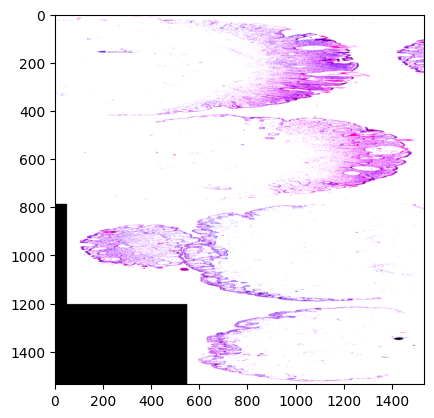

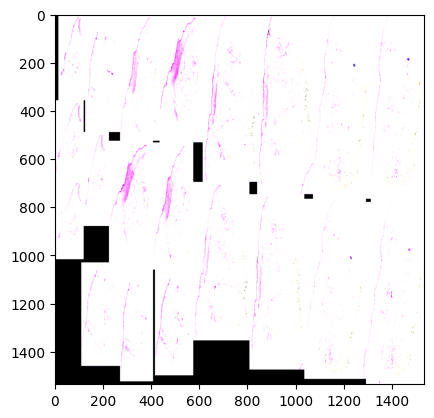

In [28]:
plt.imshow(x[0].cpu().numpy().transpose(1, 2, 0))
plt.figure()
plt.imshow(x[1].cpu().numpy().transpose(1, 2, 0))